In [61]:
import os
import joblib
import numpy as np
from qsc import Qsc
import pandas as pd
from keras.models import load_model

params = {'results_path': 'results',
          'data_path': 'data',
          'nfp': 3,
          'model': 'nn',
          'best_points': False,
          }

model_path = os.path.join(params['results_path'], f"nfp{params['nfp']}", f"nn_qsc_nfp{params['nfp']}_model{params['model']}"+("_best" if params['best_points'] else "")+".h5")
scaler_x_path = os.path.join(params['results_path'], f"nfp{params['nfp']}", f"nn_qsc_nfp{params['nfp']}_scaler_x"+("_best" if params['best_points'] else "")+".pkl")
scaler_y_path = os.path.join(params['results_path'], f"nfp{params['nfp']}", f"nn_qsc_nfp{params['nfp']}_scaler_y"+("_best" if params['best_points'] else "")+".pkl")

model = load_model(model_path)
scaler_x = joblib.load(scaler_x_path)
scaler_y = joblib.load(scaler_y_path)

In [63]:
filename = os.path.join(params['data_path'], f'qsc_out.random_scan_nfp{params["nfp"]}'+("_best" if params['best_points'] else "")+'.parquet')
df = pd.read_parquet(filename)
df.loc[:, df.columns.str.startswith('y')].head(10)

,y0,y2,y3,y4
0,0.029843,0.182455,0.687687,0.194387
1,0.048864,1.146545,0.697980,0.161539
2,0.038568,0.581099,0.563505,0.151736
3,0.153407,4.982504,0.363623,0.202438
4,1.791213,11.284778,0.212454,0.096343
5,0.427346,9.693456,0.231517,0.142567
6,2.343931,10.317529,0.168190,0.085024
7,0.413411,5.582307,0.288351,0.165770
8,0.018738,0.397689,0.706643,0.190954
9,2.567565,4.385195,0.220798,0.117005


In [71]:
def make_prediction(model, scaler, input_data):
    input_data = np.array(input_data)
    input_data_scaled = scaler.transform(input_data.reshape(1, -1))
    prediction = model.predict(input_data_scaled,verbose = 0)
    prediction = scaler_y.inverse_transform(prediction)[0]
    return prediction

In [64]:
##          y = [iota,   r_singularity, B20_variation, L_grad_B, L_grad_grad_B, min_R0, elongation, d2_volume_d_psi2, curvature, standard_deviation_of_Z, standard_deviation_of_R, helicity]
#input_Y_date = [0.029843	0.037057	0.182455	0.687687	0.194387	0.977707	15.997072	33.912338	1.172316	0.022942	0.015956	0]
# input_Y_data = [2.1, 0.08, 5.0, 0.3, 0.3, 0.5, 10.0, 2., 1.8, 0.4, 0.4, -1]
# y = [iota, B20_variation, L_grad_B, L_grad_grad_B]
input_Y_data = [2.567565,	4.385195,	0.220798,	0.117005]
prediction = make_prediction(model, scaler_x, input_Y_data)
prediction

1/1 [==============================] - 0s 33ms/step


array([-3.2118645e-01, -2.0708756e-01, -4.3554412e-04,  1.0206768e-04,
       -3.5337516e-04, -8.3948333e-05, -6.3763011e-01, -3.2364979e-02],
      dtype=float32)

In [65]:
# Print the results
n_axis_fourier_modes = int((len(prediction)-2)/2)
predicted_rc = np.append([1],prediction[0:2*n_axis_fourier_modes:2])
predicted_zs = np.append([0],prediction[1:2*n_axis_fourier_modes+1:2])
predicted_eta_bar = prediction[2*n_axis_fourier_modes]
predicted_B2c = prediction[2*n_axis_fourier_modes+1]
stel = Qsc(rc=predicted_rc, zs=predicted_zs, etabar=predicted_eta_bar, nfp=int(params['nfp']), B2c=predicted_B2c, order='r3', nphi=151)
print('------------------------------------------')
print(f'  predicted_rc      = {", ".join(["{:.3e}".format(i) for i in predicted_rc])}')
print(f'  predicted_zs      = {", ".join(["{:.3e}".format(i) for i in predicted_zs])}')
print(f'  predicted_etabar  = {predicted_eta_bar:.3e}')
print(f'  predicted_B2c     = {predicted_B2c:.3e}')
print('------------------------------------------')
print(f'  predicted_iota          = {stel.iota:.3e}')
print(f'  asked_iota              = {input_Y_data[0]:.3e}')
print(f'  predicted_r_singularity = {stel.r_singularity:.3e}')
# print(f'  asked_r_singularity     = {input_Y_data[1]:.3e}')
print(f'  predicted_B20_variation = {stel.B20_variation:.3e}')
print(f'  asked_B20_variation     = {input_Y_data[1]:.3e}')
print(f'  predicted_L_gradB       = {stel.min_L_grad_B:.3e}')
print(f'  asked_L_gradB           = {input_Y_data[2]:.3e}')
print(f'  predicted_L_gradgradB   = {1/stel.grad_grad_B_inverse_scale_length:.3e}')
print(f'  asked_L_gradgradB       = {input_Y_data[3]:.3e}')
print(f'  predicted_min_R0        = {stel.min_R0:.3e}')
# print(f'  asked_min_R0            = {input_Y_data[5]:.3e}')
print(f'  predicted_elongation    = {stel.max_elongation:.3e}')
# print(f'  asked_elongation        = {input_Y_data[6]:.3e}')
print(f'  predicted_d2_volume_d_psi2 = {stel.d2_volume_d_psi2:.3e}')
# print(f'  asked_d2_volume_d_psi2     = {input_Y_data[7]:.3e}')
print(f'  predicted_helicity      = {stel.helicity:.3e}')
# print(f'  asked_helicity          = {input_Y_data[11]:.3e}')

Methods of computing lambda disagree!! Higher nphi resolution might be needed.


------------------------------------------
  predicted_rc      = 1.000e+00, -3.212e-01, -4.355e-04, -3.534e-04
  predicted_zs      = 0.000e+00, -2.071e-01, 1.021e-04, -8.395e-05
  predicted_etabar  = -6.376e-01
  predicted_B2c     = -3.236e-02
------------------------------------------
  predicted_iota          = -2.353e+00
  asked_iota              = 2.568e+00
  predicted_r_singularity = 2.581e-02
  predicted_B20_variation = 1.203e+01
  asked_B20_variation     = 4.385e+00
  predicted_L_gradB       = 1.626e-01
  asked_L_gradB           = 2.208e-01
  predicted_L_gradgradB   = 7.468e-02
  asked_L_gradgradB       = 1.170e-01
  predicted_min_R0        = 6.780e-01
  predicted_elongation    = 1.751e+01
  predicted_d2_volume_d_psi2 = 2.678e+01
  predicted_helicity      = 1.000e+00


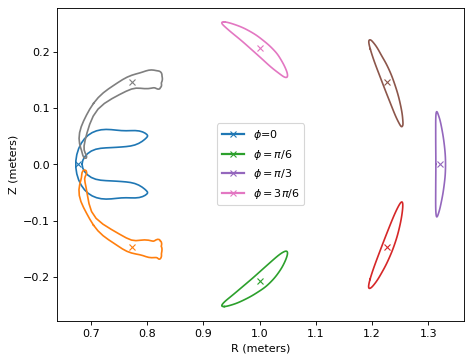

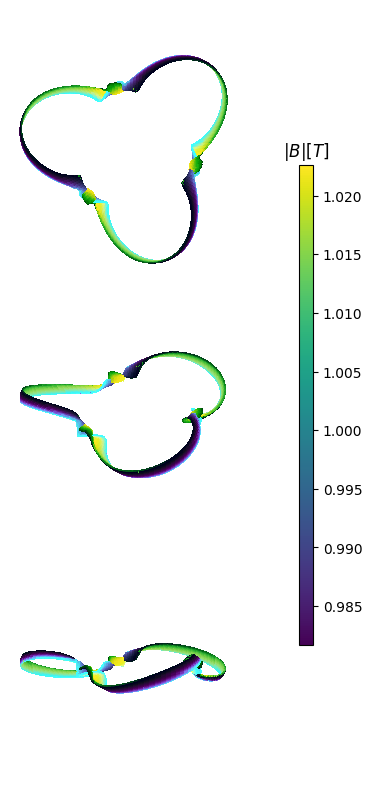

In [66]:
stel.plot_boundary(r=stel.r_singularity)

  7%|▋         | 2/30 [00:00<00:03,  8.05it/s]Methods of computing lambda disagree!! Higher nphi resolution might be needed.
Methods of computing lambda disagree!! Higher nphi resolution might be needed.
 13%|█▎        | 4/30 [00:00<00:02,  9.25it/s]Methods of computing lambda disagree!! Higher nphi resolution might be needed.
Methods of computing lambda disagree!! Higher nphi resolution might be needed.
 33%|███▎      | 10/30 [00:01<00:02,  8.64it/s]Methods of computing lambda disagree!! Higher nphi resolution might be needed.
Methods of computing lambda disagree!! Higher nphi resolution might be needed.
 40%|████      | 12/30 [00:01<00:01,  9.96it/s]Methods of computing lambda disagree!! Higher nphi resolution might be needed.
Methods of computing lambda disagree!! Higher nphi resolution might be needed.
 50%|█████     | 15/30 [00:01<00:01,  8.76it/s]Methods of computing lambda disagree!! Higher nphi resolution might be needed.
Methods of computing lambda disagree!! Higher nphi resol

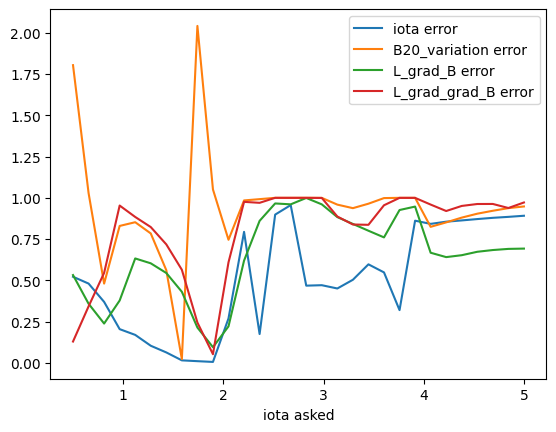

In [95]:
iota_array = np.linspace(0.5, 5.0, 30)
true_iota = []
true_B20_variation = []
true_L_grad_B = []
true_L_grad_grad_B = []
from tqdm import tqdm
for iota_asked in tqdm(iota_array):
    input_Y_data = [iota_asked,	5,	0.4,	0.2]
    prediction = make_prediction(model, scaler_x, input_Y_data)
    n_axis_fourier_modes = int((len(prediction)-2)/2)
    predicted_rc = np.append([1],prediction[0:2*n_axis_fourier_modes:2])
    predicted_zs = np.append([0],prediction[1:2*n_axis_fourier_modes+1:2])
    predicted_eta_bar = prediction[2*n_axis_fourier_modes]
    predicted_B2c = prediction[2*n_axis_fourier_modes+1]
    stel = Qsc(rc=predicted_rc, zs=predicted_zs, etabar=predicted_eta_bar, nfp=int(params['nfp']), B2c=predicted_B2c, order='r3', nphi=151)
    true_iota.append(np.abs(stel.iota))
    true_B20_variation.append(np.abs(stel.B20_variation))
    true_L_grad_B.append(np.abs(stel.min_L_grad_B))
    true_L_grad_grad_B.append(np.abs(1/stel.grad_grad_B_inverse_scale_length))
import matplotlib.pyplot as plt
plt.plot(iota_array, np.abs(np.array(iota_array)-np.array(true_iota))/np.array(iota_array), label='iota error')
plt.xlabel('iota asked')
plt.plot(iota_array, np.abs(input_Y_data[1]-np.array(true_B20_variation))/np.array(true_B20_variation), label='B20_variation error')
plt.plot(iota_array, np.abs(input_Y_data[2]-np.array(true_L_grad_B))/np.array(input_Y_data[2]), label='L_grad_B error')
plt.plot(iota_array, np.abs(input_Y_data[3]-np.array(true_L_grad_grad_B))/np.array(input_Y_data[3]), label='L_grad_grad_B error')
plt.legend()
plt.show()